In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction import DictVectorizer

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import sys
print(sys.version)


3.9.7 (default, Sep 16 2021, 13:09:58) 
[GCC 7.5.0]


# Q1 -  How many records for january ?

In [2]:
df_jan = pd.read_parquet('./data/fhv_tripdata_2021-01.parquet')
df_fev = pd.read_parquet('./data/fhv_tripdata_2021-02.parquet')

print(f"{df_jan.shape[0]} records on january")

1154112 records on january


In [3]:
df_jan.head(5)

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,None,B00013
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,None,B00037
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,None,B00037


# Q2 - What's the average trip duration in January?

In [4]:
df_jan["duration"] = (df_jan["dropOff_datetime"] - df_jan["pickup_datetime"]) / (np.timedelta64(1, 's') * 60)
df_fev["duration"] = (df_fev["dropOff_datetime"] - df_fev["pickup_datetime"]) / (np.timedelta64(1, 's') * 60)

In [5]:
print(f"Average trip duration for january is {df_jan['duration'].mean()} ")

Average trip duration for january is 19.1672240937939 


# Data preparation

Text(0.5, 1.0, 'february duration')

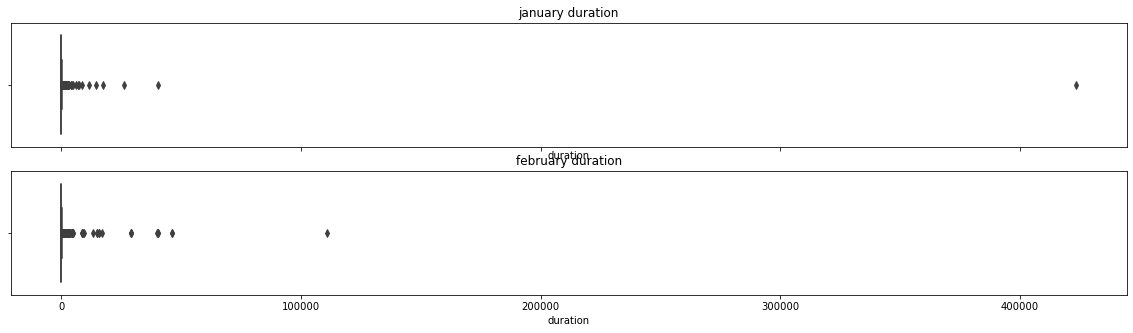

In [6]:
from matplotlib import pyplot as plt 
import seaborn as sns 

fig, axes = plt.subplots(2, 1, figsize=(20, 5),sharex=True)
sns.boxplot(ax=axes[0],x=df_jan["duration"])
axes[0].set_title('january duration')
sns.boxplot(ax=axes[1],x=df_fev["duration"])
axes[1].set_title('february duration')

In [7]:
filtered_jan = df_jan[(df_jan["duration"] >= 1) & (df_jan["duration"] <= 60)]
filtered_fev = df_fev[(df_fev["duration"] >= 1) & (df_fev["duration"] <= 60)]

Text(0.5, 1.0, 'february duration')

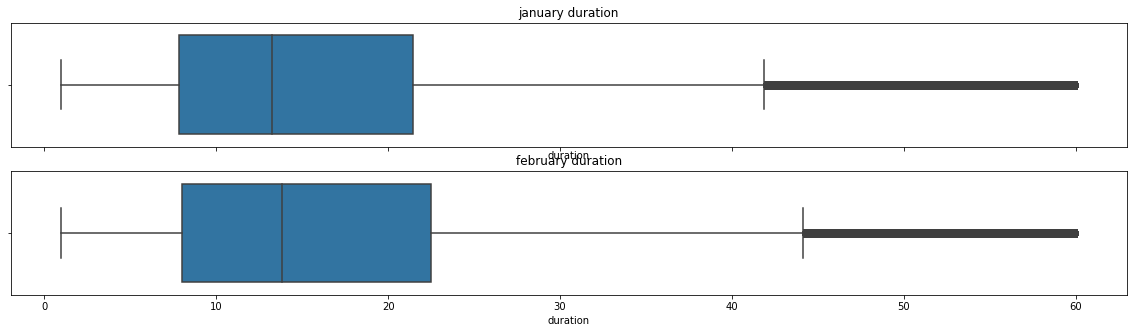

In [8]:
fig, axes = plt.subplots(2, 1, figsize=(20, 5),sharex=True)
sns.boxplot(ax=axes[0],x=filtered_jan["duration"])
axes[0].set_title('january duration')
sns.boxplot(ax=axes[1],x=filtered_fev["duration"])
axes[1].set_title('february duration')

In [9]:
print(f"{len(df_jan) - len(filtered_jan)} records dropped for january")
print(f"{len(df_fev) - len(filtered_fev)} records dropped for february")

44286 records dropped for january
47579 records dropped for february


# Q3  fractions of missing values for the pickup location ID

83.53% missing value


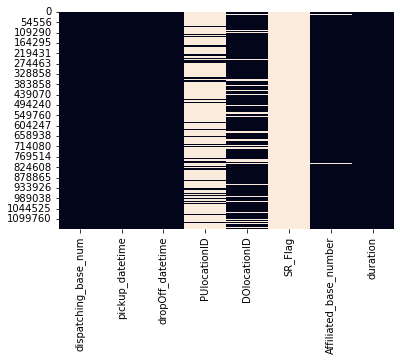

In [10]:
sns.heatmap(filtered_jan.isnull(), cbar=False)
print(f'{(filtered_jan["PUlocationID"].isnull().sum() / len(filtered_jan)) * 100:.2f}% missing value')

In [11]:
filtered_jan.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number,duration
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009,17.000000
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009,17.000000
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,None,B00037,8.283333
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,None,B00037,15.216667
5,B00037,2021-01-01 00:59:02,2021-01-01 01:08:05,NaN,71.0,None,B00037,9.050000


In [18]:
filtered_jan["PUlocationID"].fillna(-1, inplace=True) 
filtered_jan["DOlocationID"].fillna(-1, inplace=True) 

# Q4 - dim after one hot encode
one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.

 -   Turn the dataframe into a list of dictionaries
 -   Fit a dictionary vectorizer
 -   Get a feature matrix from it


In [20]:
categorical = ["PUlocationID", "DOlocationID"]
filtered_jan[categorical] = filtered_jan[categorical].astype(str)

train_dicts = filtered_jan[categorical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

print(f'{X_train.shape[1]} dimensions')

525 dimensions


# Q5 Train linear reg, check rmse

In [14]:
y_train = filtered_jan["duration"]

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)
mean_squared_error(y_train, y_pred, squared=False)

10.528519107208234

# Q6 evaluate 

In [21]:
df_fev["duration"] = (df_fev["dropOff_datetime"] - df_fev["pickup_datetime"]) / (np.timedelta64(1, 's') * 60)
filtered_fev = df_fev[(df_fev["duration"] >= 1) & (df_fev["duration"] <= 60)]
filtered_fev["PUlocationID"].fillna(-1, inplace=True) 
filtered_fev["DOlocationID"].fillna(-1, inplace=True) 

filtered_fev[categorical] = filtered_fev[categorical].astype(str)

val_dicts = filtered_fev[categorical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_val = filtered_fev['duration']

assert X_train.shape[1] == X_train.shape[1]


In [16]:
y_pred = lr.predict(X_val)
mean_squared_error(y_val, y_pred, squared=False)


11.01428316004532